In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from ladybug.sunpath import Sunpath

import oshe as tc
idd_file = r"C:\openstudio-2.7.0\EnergyPlus\Energy+.idd"

In [2]:
# Load case recipe

json_location = "./projects/AirportRd/P2/recipe.json"
reload = False
output_directory = os.path.dirname(os.path.dirname(json_location))

# Create output directory for generated images
plot_directory = os.path.join(os.path.dirname(json_location), "plots")
if not os.path.exists(plot_directory):
    os.mkdir(plot_directory)

# Load JSON
d = tc.helpers.load_json(json_location)

In [3]:
# Load data referenced during processing

# Load epw
epw_file = d["epw"]
epw = EPW(epw_file)

# Load points
points = np.array(d["points"])

# Get climate variables
dbt = np.array(epw.dry_bulb_temperature.values)
rh = np.array(epw.relative_humidity.values)
ws = np.array(epw.wind_speed.values)
hir = np.array(epw.horizontal_infrared_radiation_intensity.values)

# Calculate hourly solar altitudes and hir for input
sun_path = Sunpath.from_location(epw.location)
sun_altitude = np.array([sun_path.calculate_sun_from_hoy(i).altitude for i in range(8760)])

# Load surface view factors
surface_view_factors = np.array(d["surface_view_factors"])

# Load sky view factors
sky_view_factors = np.array([[i] for i in d["sky_view_factors"]]) / 100 * 0.5

# Load ground reflectivities
ground_reflectivities = np.array([[i] for i in d["ground_reflectivities"]])

# Load plot tricontour plot 
boundary = np.array(d["boundary"])[:, :-1]

In [4]:
# Read EnergyPlus annual ourly surface temperature results
surface_temperatures = tc.helpers.load_energyplus_results(d["eplus_results"])

# Read Radiance simulation annual hourly incident radiation results
radiation_direct, radiation_diffuse = tc.helpers.load_radiance_results(d["radiation_results"])

EnergyPlus results loaded
Radiance results loaded


In [5]:
# Calculate surrounding surface temperature (including sky)

# Calculate generic sky temperature
sktemp = tc.oshe.calc_sky_temperature(hir)

# Append sky temperature and air temperature onto end of surface temperatures
all_srf_temps = np.vstack([surface_temperatures, sktemp, dbt])

# Append sky view factor to end of surface view factors
all_vfs = np.hstack([surface_view_factors, sky_view_factors])

# Add view factor to end of each group, bringing total to 1
makeups = np.where(1 - all_vfs.sum(axis=1) <= 0, 0, 1 - all_vfs.sum(axis=1))
all_vfs = np.vstack([all_vfs.T, makeups]).T

# Normalise view factors to 0-1
all_vfs = all_vfs.T * (1 / all_vfs.sum(axis=1))

# Calculate overall surrounding surface temperature using view factors and individual surface temperatures
surrounding_surface_temperatures = np.power(np.matmul(all_vfs.T, np.power(all_srf_temps.T + 273.15, 4).T), 0.25) - 273.15

In [6]:
# SURFACE TEMPERATURE - OLD METHOD

# if not reload:
#     # Normalise the view factors to range from 0-1 total
#     surface_view_factors = np.array([np.divide(pt, pt.sum(), out=np.zeros_like(pt), where=pt.sum() != 0) for pt in surface_view_factors])

#     # Calcluate the longwave MRT from visible surface temperature and view factors
#     longwave_mrt = np.power(np.matmul(surface_view_factors, np.power(surface_temperatures.T + 273.15, 4).T), 0.25) - 273.15
#     longwave_mrt = np.where(longwave_mrt == 0, 0, longwave_mrt - 273.15)

#     # Find null indices (where longwave mrt is 0 throughout entire year indicating null conditions)
#     null_indices = np.nonzero(longwave_mrt.sum(axis=1) == 0)[0]

#     # Get average annual longwave conditions for all points
#     median_lwmrt = np.percentile(longwave_mrt, 50, axis=0)

#     # Replace null indices with median
#     for ii in null_indices:
#         longwave_mrt[ii] = median_lwmrt

In [7]:
# Calculate MRT and write to file

if not reload:
    
    n_pts = 1000000
    mean_radiant_temperature = tc.mrt.mean_radiant_temperature(
        surrounding_surfaces_temperature=surrounding_surface_temperatures[:n_pts],
        horizontal_infrared_radiation_intensity=hir, 
        diffuse_horizontal_solar=radiation_diffuse.T[:n_pts], 
        direct_normal_solar=radiation_direct.T[:n_pts], 
        sun_altitude=sun_altitude, 
        ground_reflectivity=0.01,#ground_reflectivities[:n_pts], # Remove refletced radiation as this is accounted for in the Radiance run
        sky_exposure=sky_view_factors[:n_pts], 
        radiance=True
    )[0]

    # Write to file
    df_mrt = pd.DataFrame(mean_radiant_temperature.T)
    df_mrt.round(6).to_csv(os.path.join(os.path.dirname(json_location), "result.mrt"), index=False)
    
else:
    mean_radiant_temperature = pd.read_csv(os.path.join(os.path.dirname(json_location), "result.mrt")).values.T
    print("MRT reloaded from {}".format(os.path.join(os.path.dirname(json_location), "result.mrt")))


Mean radiant temperature calculated [163.34 seconds]


In [8]:
# Calculate UTCI and write to file

if not reload:
    
    n_pts = 1000000
    universal_thermal_climate_index = tc.utci.universal_thermal_climate_index(dbt, mean_radiant_temperature[:n_pts], ws, rh)

    # Write to file
    df_utci = pd.DataFrame(universal_thermal_climate_index.T)
    df_utci.round(6).to_csv(os.path.join(os.path.dirname(json_location), "result.utci"), index=False)

else:
    universal_thermal_climate_index = pd.read_csv(os.path.join(os.path.dirname(json_location), "result.utci")).values.T
    print("UTCI reloaded from {}".format(os.path.join(os.path.dirname(json_location), "result.utci")))


Universal thermal climate index calculated [85.94 seconds]


In [9]:
# Simulate open field MRT and UTCI and write to file

if not reload:
    # Define ground
    ground = tc.ground.Ground(ground_type="Concrete")
    
    # Calculate UTCI for open field
    ground.utci(epw_file=epw_file, idd_file=idd_file, case_name="openfield", output_directory=output_directory, write=True)

    of_mrt = ground.mean_radiant_temperature
    of_utci = ground.universal_thermal_climate_index
else:
    of_utci = pd.read_csv(os.path.join(output_directory, "openfield/openfield.utci")).T.values


Ground surface temperature simulation completed
EnergyPlus results loaded
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.08 seconds]
MRT file written to projects\AirportRd\openfield/openfield.mrt
Universal thermal climate index calculated [0.12 seconds]
UTCI file written to projects\AirportRd\openfield/openfield.utci


In [10]:
# Construct results object

utci = tc.plot.UTCI(of_utci, universal_thermal_climate_index, points)

Calculating UTCI comfort levels
Calculating UTCI openfield reduction levels


In [11]:
# Generate Openfield sumary

utci.openfield_summary()

,Open field,UTCI,Time,Annual,May,October
0,Comfort,9-26,07:00-10:00,44.726027,11.290323,19.354839
1,Comfort,9-26,16:00-19:00,34.739726,0.000000,0.645161
2,Comfort + slight heat stress,9-28,07:00-10:00,51.095890,29.838710,38.709677
3,Comfort + slight heat stress,9-28,16:00-19:00,39.013699,1.290323,3.870968


In [12]:
# Load Radiance geometry

rad_files = [
    os.path.join(os.path.dirname(d["radiation_results"]), "scene", "opaque", "{}..opq.rad".format(os.path.basename(os.path.dirname(json_location)))),
    os.path.join(os.path.dirname(d["radiation_results"]), "scene", "glazing", "{}..glz.rad".format(os.path.basename(os.path.dirname(json_location))))
]

Plot saved to ./projects/AirportRd/P2\plots\_improvement_october_morningafternoonshoulder.png


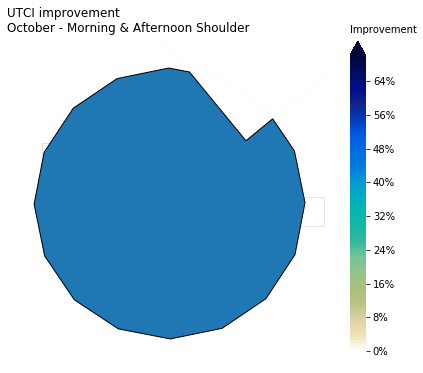

In [22]:
# Plot comfort and reduction plan

for t in ["comfort", "reduction", "improvement"][-1:]:
    for s_period in ["Annual", "May", "October"][-1:]:
        for d_period in ["Morning Shoulder", "Afternoon Shoulder", "Morning & Afternoon Shoulder"][-1:]:
            
            sp = os.path.join(plot_directory, "_{0:}_{1:}_{2:}.png".format(t, s_period.lower(), d_period.lower()).replace("&", "").replace(" ", ""))
            
            utci.plot_plan(rad_files, _type=t, day_period=d_period, season_period=s_period, save_path=sp, pts=False, label_pts=None, legend=False, highlight_pt=None, clip=boundary, tone_color="k", close=False)

In [14]:
# Plot context plan

utci.plot_plan(rad_files, save_path=os.path.join(plot_directory, "context.png"), pts=False, label_pts=None, legend=True, highlight_pt=None, tone_color="k", close=True)
utci.plot_plan(rad_files, save_path=os.path.join(plot_directory, "context_ptlabels.png"), pts=True, label_pts=2, legend=True, highlight_pt=None, tone_color="k", close=True)

Plot saved to ./projects/AirportRd/P2\plots\context.png
Plot saved to ./projects/AirportRd/P2\plots\context_ptlabels.png


In [15]:
# Review pt locations and choose focal pts for plotting

if "P1" in json_location:
    focus_pts = [1148, 1597, 1672, 1880]  # P1
elif "P2" in json_location:
    focus_pts = [829, 1344, 1222]  # P2
elif "P3" in json_location:
    focus_pts = [1416, 1516, 1524]  # P3
elif "FAMILYPARK1" in json_location:
    focus_pts = [328, 414, 566, 1046]
elif "FAMILYPARK2" in json_location:
    focus_pts = [100, 636, 860, 1038, 1088, 1202]

utci.plot_plan(rad_files, save_path=os.path.join(plot_directory, "focuspoints_location.png"), pts=False, label_pts=None, legend=True, highlight_pt=focus_pts, tone_color="k", close=True)

Plot saved to ./projects/AirportRd/P2\plots\focuspoints_location.png


In [16]:
# Plot UTCI day and heatmap comparison plots for focus pts

for pt_idx in focus_pts[0:]:
    for period in ["May", "October", "May & October"]:
        sp = os.path.join(plot_directory, "pt{0:04.0f}_profile_{1:}.png".format(pt_idx, period.lower()).replace("&", "").replace(" ", ""))
        utci.utci_day_comparison(point_idx=pt_idx, period=period, tone_color="k", save_path=sp, close=True)

Plot saved to ./projects/AirportRd/P2\plots\pt0829_profile_may.png
Plot saved to ./projects/AirportRd/P2\plots\pt0829_profile_october.png
Plot saved to ./projects/AirportRd/P2\plots\pt0829_profile_mayoctober.png
Plot saved to ./projects/AirportRd/P2\plots\pt1344_profile_may.png
Plot saved to ./projects/AirportRd/P2\plots\pt1344_profile_october.png
Plot saved to ./projects/AirportRd/P2\plots\pt1344_profile_mayoctober.png
Plot saved to ./projects/AirportRd/P2\plots\pt1222_profile_may.png
Plot saved to ./projects/AirportRd/P2\plots\pt1222_profile_october.png
Plot saved to ./projects/AirportRd/P2\plots\pt1222_profile_mayoctober.png


In [17]:
# Plot comfort heatmaps for each pt

utci.utci_heatmap(save_path=os.path.join(plot_directory, "openfield_comfortheatmap.png".format(pt_idx)), close=True)

for pt_idx in focus_pts[0:]:
    sp = os.path.join(plot_directory, "pt{0:04.0f}_comfortheatmap.png".format(pt_idx))
    utci.utci_heatmap(point_idx=pt_idx, save_path=sp, close=True)

Plot saved to ./projects/AirportRd/P2\plots\openfield_comfortheatmap.png
Plot saved to ./projects/AirportRd/P2\plots\pt0829_comfortheatmap.png
Plot saved to ./projects/AirportRd/P2\plots\pt1344_comfortheatmap.png
Plot saved to ./projects/AirportRd/P2\plots\pt1222_comfortheatmap.png


In [18]:
# Plot reduction heatmaps for each pt

for pt_idx in focus_pts[0:]:
    sp = os.path.join(plot_directory, "pt{0:04.0f}_reductionheatmap.png".format(pt_idx))
    utci.utci_reduction_heatmap(point_idx=pt_idx, save_path=sp, close=True)

Plot saved to ./projects/AirportRd/P2\plots\pt0829_reductionheatmap.png
Plot saved to ./projects/AirportRd/P2\plots\pt1344_reductionheatmap.png
Plot saved to ./projects/AirportRd/P2\plots\pt1222_reductionheatmap.png


In [20]:
# Tile images for ease of inserting into Word!

from PIL import Image

def get_concat_h2(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_h3(im1, im2, im3):
    dst = Image.new('RGB', (im1.width + im2.width + im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_v3(im1, im2, im3):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height + im3.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    dst.paste(im3, (0, im1.height + im2.height))
    return dst

for t in ["comfort", "reduction", "improvement"][0:]:
    column = []
    for s_period in ["Annual", "May", "October"][0:]:
        row = []
        for d_period in ["Morning Shoulder", "Afternoon Shoulder", "Morning & Afternoon Shoulder"][0:-1]:
            
            sp = os.path.join(plot_directory, "_{0:}_{1:}_{2:}.png".format(t, s_period.lower(), d_period.lower()).replace("&", "").replace(" ", ""))
            row.append(Image.open(sp))
        column.append(row)

    b = []
    for r in column:
        b.append(get_concat_h2(r[0], r[1]))
    
    c = get_concat_v3(b[0], b[1], b[2])
    planpath = os.path.join(plot_directory, "_{0:}__collection.png".format(t).replace("&", "").replace(" ", ""))
    print("Contour plots joined in {}".format(planpath))
    c.save(planpath)

for pt_idx in focus_pts[0:]:
    
    spcomf = Image.open(os.path.join(plot_directory, "pt{0:04.0f}_comfortheatmap.png".format(pt_idx)))
    spred = Image.open(os.path.join(plot_directory, "pt{0:04.0f}_reductionheatmap.png".format(pt_idx)))
    
#     fix image width issue
    # profiles
    st = []
    for period in ["May", "October"]:
        sp = os.path.join(plot_directory, "pt{0:04.0f}_profile_{1:}.png".format(pt_idx, period.lower()).replace("&", "").replace(" ", ""))
        st.append(Image.open(sp))
    a = get_concat_h2(st[0], st[1])
    a.save(os.path.join(plot_directory, "pt{0:04.0f}_profile_collected.png".format(pt_idx).replace("&", "").replace(" ", "")))
    # resize profiles
    basewidth = 4470
    wpercent = (basewidth/float(a.size[0]))
    hsize = int((float(a.size[1])*float(wpercent)))
    a = a.resize((basewidth, hsize), Image.ANTIALIAS)
    b = get_concat_v3(spcomf, spred, a)
    point_path = os.path.join(plot_directory, "pt{0:04.0f}_collected.png".format(pt_idx).replace("&", "").replace(" ", ""))
    print("Point plots joined in {}".format(point_path))
    b.save(point_path)

Contour plots joined in ./projects/AirportRd/P2\plots\_comfort__collection.png
Contour plots joined in ./projects/AirportRd/P2\plots\_reduction__collection.png
Contour plots joined in ./projects/AirportRd/P2\plots\_improvement__collection.png
Point plots joined in ./projects/AirportRd/P2\plots\pt0829_collected.png
Point plots joined in ./projects/AirportRd/P2\plots\pt1344_collected.png
Point plots joined in ./projects/AirportRd/P2\plots\pt1222_collected.png
